# Project: Insights from TMDB Movies

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The TMDB Movies data set contains films and associated data for more than 10,000 films.  The data contains independent variables (e.g. release date, tagline, director, overview, etc.) and depenent variables (e.g. popularity, revenue_adj, vote_average, etc.).  The data can be used to draw conclusions about the films that were released between 1966 and 2015.

A few questions that can be answered with this data are:
1. Is there a correlation between the highest rated films and their revenue?
2. What genre is the highest grossing?  Most popular?
3. Which films are most viewed but lowest rated?  Are there any factors that contribute to this?
4. After account for inflation, how has the money grossed by films changed over time?
5. What actors are consistently in highly rated films?  Highly grossing?

Import packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Load the dataset and check the shape of the dataframe.

In [2]:
df = pd.read_csv('tmdb-movies.csv')
df.shape

(10866, 21)

Check the columns in the data set and the data integrity of each field.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

First, remove the columns that won't be useful for this analysis:
- id
- imdb_id
- homepage
- tagline
- keywords
- overview
- production_companies


While there is generally 10,866 records, some issues exist:
1. imdb_id is missing 10 values (_can likely drop record_)
2. cast is missing ~100 values
3. homepage only has 2,936 values (_can likely drop this entire field_)
4. director is missing a trivial amount of records (_have a look at these and potentially drop records)
5. tagline is missing over 2,000 values (_can likely drop this field_)
6. keywords is missing ~1,000 values (_could be OK as this field is interesting but blanks may not provide or detract value_)
7. overview is missing 4 values
8. genres is missing 23 values
9. production_companies is missing ~1,000 values (_look into this, if columns is dropped, need to re-evaluate dataset questions_)

### Data Cleaning

Remove the columns that are unnecessary for this analysis

In [4]:
df.drop(['id','imdb_id','homepage','tagline','keywords','overview','production_companies'], axis=1,inplace=True);

__1. Drop 10 rows where imdb_id is missing__

No longer needed since we dropped the column imdb_id as being unnecessary for this analysis

__2. cast is missing ~100 values__

In [5]:
df[df['cast'].isnull()].head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
371,0.422901,0,0,Sanjay's Super Team,NaN,Sanjay Patel,7,Animation,11/25/15,47,6.9,2015,0.0,0.0
441,0.220751,0,0,Winter on Fire: Ukraine's Fight for Freedom,NaN,Evgeny Afineevsky,98,Documentary,10/9/15,37,8.2,2015,0.0,0.0
465,0.201696,0,0,Bitter Lake,NaN,Adam Curtis,135,Documentary,1/24/15,19,7.8,2015,0.0,0.0
536,0.122543,0,0,A Faster Horse,NaN,David Gelb,90,Documentary,10/8/15,12,8.0,2015,0.0,0.0
538,0.114264,0,0,The Mask You Live In,NaN,Jennifer Siebel Newsom,88,Documentary,1/1/15,11,8.9,2015,0.0,0.0


It's apparent that most of the null movies are Documentary or Animated, so this could be a legitimate value.  Let's look further at all Documentary to see what % have null cast:

In [6]:
df[df['genres'].str.contains("Documentary", na=False)].popularity.count()

520

520 films have genre containing Documentary

In [7]:
null_cast = pd.DataFrame(df[df['cast'].isnull()])
null_cast_doc = null_cast[null_cast['genres'].str.contains("Documentary", na=False)];

In [8]:
null_cast_doc.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 441 to 9564
Data columns (total 14 columns):
popularity        42 non-null float64
budget            42 non-null int64
revenue           42 non-null int64
original_title    42 non-null object
cast              0 non-null object
director          39 non-null object
runtime           42 non-null int64
genres            42 non-null object
release_date      42 non-null object
vote_count        42 non-null int64
vote_average      42 non-null float64
release_year      42 non-null int64
budget_adj        42 non-null float64
revenue_adj       42 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 4.9+ KB


Of the 519 Documentaries, 42 have no cast, which is 8%.  Since this is a significant number, null values for Cast will be acceptable for this analysis, given that Documentaries and animated films may have no actors.

__3. homepage only has 2,936 values__
>This field was dropped as it was deemed unnecessary for this analysis.

__4. director is missing a trivial amount of records (_have a look at these and potentially drop records_)__

In [9]:
df[df['director'].isnull()].popularity.count()

44

It's worth dropping these records as 44 out of 10,000 is trivial to be able to have consistent data

In [10]:
df.dropna(subset = ['director'], inplace=True);

__5. tagline is missing over 2,000 values (_can likely drop this field_)__

__6. keywords is missing ~1,000 values (_could be OK as this field is interesting but blanks may not provide or detract value_)__

__7. overview is missing 4 values__

All of these columns were dropped since they were deemed unnecessary for this analysis

__8. genres is missing 23 values__

In [11]:
df.dropna(subset = ['genres'], inplace=True);

__9. production_companies is missing ~1,000 values (_look into this, if columns is dropped, need to re-evaluate dataset questions_)__

This column was dropped since it was deemed unnecessary for this analysis

In [12]:
df.info();

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10801 entries, 0 to 10865
Data columns (total 14 columns):
popularity        10801 non-null float64
budget            10801 non-null int64
revenue           10801 non-null int64
original_title    10801 non-null object
cast              10732 non-null object
director          10801 non-null object
runtime           10801 non-null int64
genres            10801 non-null object
release_date      10801 non-null object
vote_count        10801 non-null int64
vote_average      10801 non-null float64
release_year      10801 non-null int64
budget_adj        10801 non-null float64
revenue_adj       10801 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 1.2+ MB


There are now __10,801__ clean records of data, with the exception of cast having 69 missing values, which are expected

After reviewing histograms, it's apparent that there are 5,952 cases where revenue was not recorded.

5952

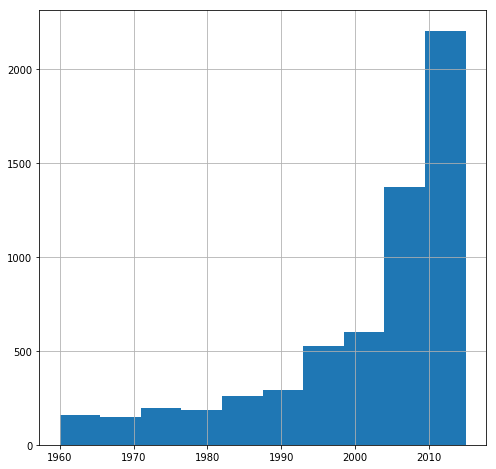

In [13]:
rev_zero = df[df['revenue_adj']==0]
rev_zero['release_year'].hist(figsize=(8,8))
rev_zero.popularity.count()

Seeing that this is half of the dataset sample size, and range of dates with no recorded revenue are mostly recent but span the entire dataset, removing this data will significantly affect the datatset.  However, given most of the dataset questions incorporate revenue, it will be best to keep this value where it exists.  After checking any correlation between revenue and budget (none exists), there is no simple way to extrapolate this data so these rows will simply be removed.

In [14]:
df = df[df['revenue_adj']!=0];

Similarly for budget

In [15]:
df = df[df['budget']!=0];

In [16]:
df[df['budget']<10000].popularity.count()

25

Given there are 25 movies with a budget of less than 10,000, these will be removed as well since that's an unrealistic budget for a movie and will skew our results.

In [17]:
df=df[df['budget']>10000];

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3828 entries, 0 to 10848
Data columns (total 14 columns):
popularity        3828 non-null float64
budget            3828 non-null int64
revenue           3828 non-null int64
original_title    3828 non-null object
cast              3825 non-null object
director          3828 non-null object
runtime           3828 non-null int64
genres            3828 non-null object
release_date      3828 non-null object
vote_count        3828 non-null int64
vote_average      3828 non-null float64
release_year      3828 non-null int64
budget_adj        3828 non-null float64
revenue_adj       3828 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 448.6+ KB


There are now __3,828__ clean records of data, with the exception of cast having 3 missing values, which are expected

<a id='eda'></a>
## Exploratory Data Analysis

Let's by looking at the histograms of each column in our clean data:

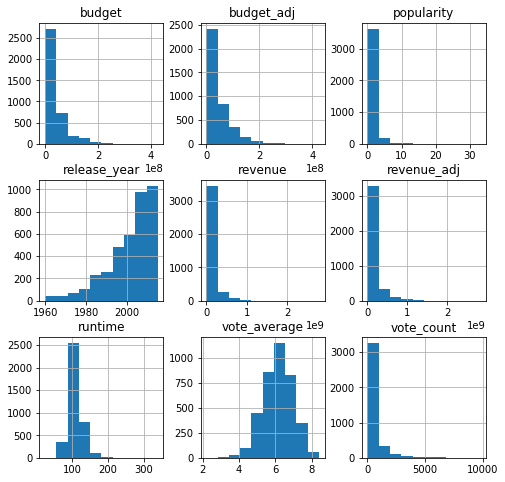

In [19]:
df.hist(figsize=(8,8));

In [20]:
df.describe()

,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,3828.000000,3.828000e+03,3.828000e+03,3828.000000,3828.000000,3828.000000,3828.000000,3.828000e+03,3.828000e+03
mean,1.196928,3.746312e+07,1.083809e+08,109.255486,530.720742,6.168913,2001.275601,4.454719e+07,1.379222e+08
std,1.478507,4.223619e+07,1.769268e+08,19.856581,882.114133,0.795069,11.281562,4.480798e+07,2.165623e+08
min,0.001117,1.200000e+04,2.000000e+00,26.000000,10.000000,2.200000,1960.000000,1.577503e+04,2.370705e+00
25%,0.465717,1.000000e+07,1.400802e+07,96.000000,72.000000,5.700000,1995.000000,1.337542e+07,1.879153e+07
50%,0.802740,2.400000e+07,4.565877e+07,106.000000,206.000000,6.200000,2004.000000,3.030653e+07,6.230869e+07
75%,1.379884,5.000000e+07,1.249894e+08,119.000000,582.250000,6.700000,2010.000000,6.076720e+07,1.646753e+08
max,32.985763,4.250000e+08,2.781506e+09,338.000000,9767.000000,8.400000,2015.000000,4.250000e+08,2.827124e+09


### Question 1: How does runtime affect the vote ratings of a movie?

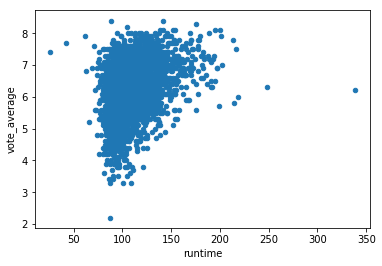

In [21]:
df.plot(x='runtime', y='vote_average', kind='scatter');

After having a look at the scatterplot of runtime versus average vote, it's distinguishable that longer movies tend to get higher votes.  Let's look at the details, considering 106 minutes as a short movie and longer than 106 minutes a long movie.

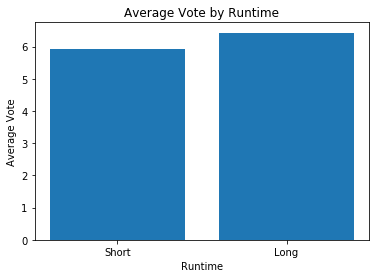

In [22]:
short = df[df['runtime']<=106] #shorter than or equal to median
long = df[df['runtime']>106] # longer than median
mean_voteavg_short = short['vote_average'].mean() #take the mean of the short movies
mean_voteavg_long = long['vote_average'].mean() #take the mean of the long movies
locations = [1,2]
heights = [mean_voteavg_short, mean_voteavg_long]
labels = ['Short', 'Long']
plt.bar(locations, heights, tick_label=labels) #generate a bar chart
plt.title('Average Vote by Runtime')
plt.xlabel('Runtime')
plt.ylabel('Average Vote');

In [23]:
mean_voteavg_short, mean_voteavg_long

(5.9305278884462149, 6.4319230769230771)

While not necessarily a significant difference, there is still slight correlation between runtime and ratings.  The movies longer than the median receive half a vote higher than those shorter than the  median.

### Question 2: Which genres are correlated with greater revenue?

First, find unique genres since each film can have multiple genres associated with it.

In [24]:
df['genres'].head(50);

Create a mask for each genre

In [25]:
action_df = df[df['genres'].str.contains("Action", na=False)]
adventure_df = df[df['genres'].str.contains("Adventure", na=False)]
animation_df = df[df['genres'].str.contains("Animation", na=False)]
crime_df = df[df['genres'].str.contains("Crime", na=False)]
documentary_df = df[df['genres'].str.contains("Documentary", na=False)]
drama_df = df[df['genres'].str.contains("Drama", na=False)]
family_df = df[df['genres'].str.contains("Family", na=False)]
fantasy_df = df[df['genres'].str.contains("Fantasy", na=False)]
history_df = df[df['genres'].str.contains("History", na=False)]
horror_df = df[df['genres'].str.contains("Horror", na=False)]
mystery_df = df[df['genres'].str.contains("Mystery", na=False)]
romance_df = df[df['genres'].str.contains("Romance", na=False)]
scifi_df = df[df['genres'].str.contains("Science Fiction", na=False)]
thriller_df = df[df['genres'].str.contains("Thriller", na=False)]
war_df = df[df['genres'].str.contains("War", na=False)]
western_df = df[df['genres'].str.contains("Western", na=False)]

Calculate the mean per genre of various data points that can be compared on a bar chart.

In [26]:
action_mean_rev = action_df['revenue_adj'].mean()
adventure_mean_rev = adventure_df['revenue_adj'].mean()
animation_mean_rev = animation_df['revenue_adj'].mean()
crime_mean_rev = crime_df['revenue_adj'].mean()
documentary_mean_rev = documentary_df['revenue_adj'].mean()
drama_mean_rev = drama_df['revenue_adj'].mean()
family_mean_rev = family_df['revenue_adj'].mean()
fantasy_mean_rev = fantasy_df['revenue_adj'].mean()
history_mean_rev = history_df['revenue_adj'].mean()
horror_mean_rev = horror_df['revenue_adj'].mean()
mystery_mean_rev = mystery_df['revenue_adj'].mean()
romance_mean_rev = romance_df['revenue_adj'].mean()
scifi_mean_rev = scifi_df['revenue_adj'].mean()
thriller_mean_rev = thriller_df['revenue_adj'].mean()
war_mean_rev = war_df['revenue_adj'].mean()
western_mean_rev = western_df['revenue_adj'].mean()


Create a bar chart for revenue versus genre

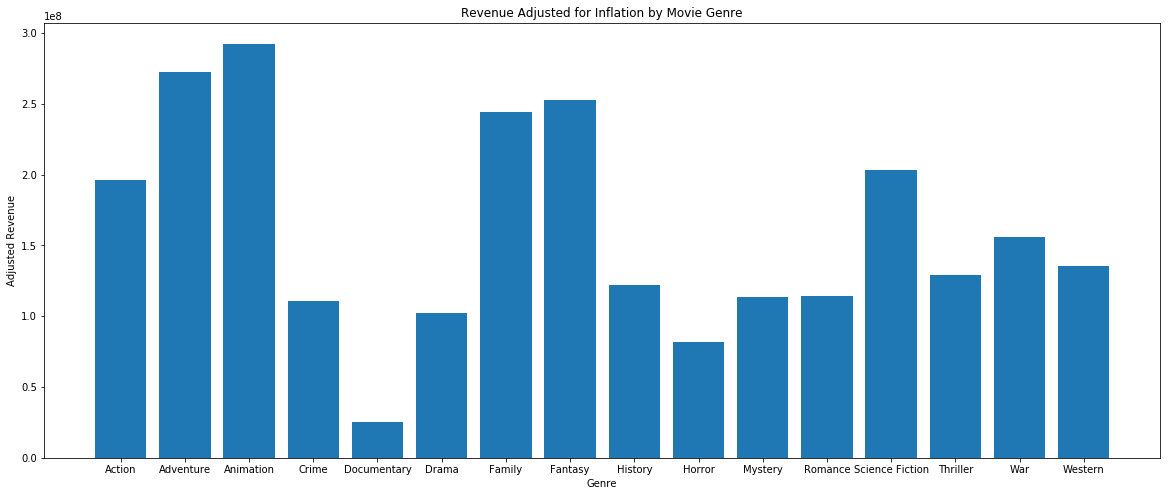

In [27]:
locations = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
heights = [action_mean_rev,adventure_mean_rev,animation_mean_rev,crime_mean_rev,documentary_mean_rev,drama_mean_rev,family_mean_rev,fantasy_mean_rev,history_mean_rev,horror_mean_rev,mystery_mean_rev,romance_mean_rev,scifi_mean_rev,thriller_mean_rev,war_mean_rev,western_mean_rev]
labels = ['Action','Adventure','Animation','Crime','Documentary','Drama','Family','Fantasy','History','Horror','Mystery','Romance','Science Fiction','Thriller','War','Western']
plt.figure(figsize=(20,8))
plt.bar(locations, heights, tick_label=labels)
plt.title('Revenue Adjusted for Inflation by Movie Genre')
plt.xlabel('Genre')
plt.ylabel('Adjusted Revenue');

A few genres that tend to make __more revenue__:

- Adventure
- Animation
- Family
- Fantasy

A few genres that tend to make __less revenue__:

- Documentary
- Horror

<a id='conclusions'></a>
## Conclusions

The TMDB Movies data set had quite a few data integrity issues but was still able to provide us with 2 interesting insights.  It's apparent that movies running longer than 106 minutes will on average receive half a vote higher in rating than movies running less than 106 minutes.  I guess folks like longer movies!  We've also learned that a few genres, such as Adventure and Animation, will earn more revenue on averge (on the scale of hundreds of millions), than genres such as Documentaries or Horror.  

A number of lessons learned were identified during this end to end data analysis process:
1. It would be effective to understand data definitions of a dataset when performing this sort of analysis.  I threw away 70% of the data because it had blank values for revenue or budget.  An alternative would be to identify patterns or correlations with other data points in order to extrapolate out predictive values in those fields.
2. The .contains() function is quite useful for creating data masks when parsing is a coding limitation
3. There is much to learn about making a figure pretty and illustrative, to ensure the figure it telling the proper message.
4. The ability to write functions and embed them in the Jupyter Notebook is something I'd like to learn and be able to apply in the near future.  I did way too much typing for the masks of the genres and it's not sustainable/scalable.

In [29]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0